### IMPORT LIBRARIES

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.backend as K

In [66]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [67]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [68]:
#train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="training",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )

train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [69]:
#valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="validation",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [70]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [71]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [72]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [73]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [74]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 62720)             250880    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2007072   
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)               

In [75]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [76]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [77]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [78]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [79]:
'''
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

'''

'\ndef exponential_decay(lr0, s):\n    def exponential_decay_fn(epoch):\n        return lr0 * 0.1 **(epoch / s)\n    return exponential_decay_fn\n\nexponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs\n\nlr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)\n\n'

In [80]:
from tensorflow.keras.utils import to_categorical, plot_model
#plot_model(model, to_file='NN-mnist.png', show_shapes=True)

In [81]:
#model.load_weights("/kaggle/input/zahaimar-22/zahaimar_v2.h5")

In [82]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [83]:

history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        verbose = 1,
                        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
                 )

Epoch 1/50
129/129 [==============================] - 113s 838ms/step - loss: 1.0988 - accuracy: 0.7491 - precision: 0.4965 - recall: 0.2430 - auc: 0.7662 - f1_score: 0.3219 - val_loss: 1.0928 - val_accuracy: 0.7581 - val_precision: 0.6542 - val_recall: 0.0684 - val_auc: 0.7631 - val_f1_score: 0.1220


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
129/129 [==============================] - 105s 812ms/step - loss: 1.0276 - accuracy: 0.7642 - precision: 0.5647 - recall: 0.2482 - auc: 0.7919 - f1_score: 0.3380 - val_loss: 1.0142 - val_accuracy: 0.7735 - val_precision: 0.5863 - val_recall: 0.3187 - val_auc: 0.7970 - val_f1_score: 0.4096
Epoch 3/50
129/129 [==============================] - 102s 791ms/step - loss: 1.0025 - accuracy: 0.7796 - precision: 0.6299 - recall: 0.2875 - auc: 0.8056 - f1_score: 0.3890 - val_loss: 0.9668 - val_accuracy: 0.7857 - val_precision: 0.6347 - val_recall: 0.3363 - val_auc: 0.8148 - val_f1_score: 0.4368
Epoch 4/50
129/129 [==============================] - 101s 784ms/step - loss: 0.9661 - accuracy: 0.7878 - precision: 0.6661 - recall: 0.3028 - auc: 0.8196 - f1_score: 0.4160 - val_loss: 0.9454 - val_accuracy: 0.7874 - val_precision: 0.6248 - val_recall: 0.3744 - val_auc: 0.8192 - val_f1_score: 0.4663
Epoch 5/50
129/129 [==============================] - 102s 786ms/step - loss: 0.9493 - accurac

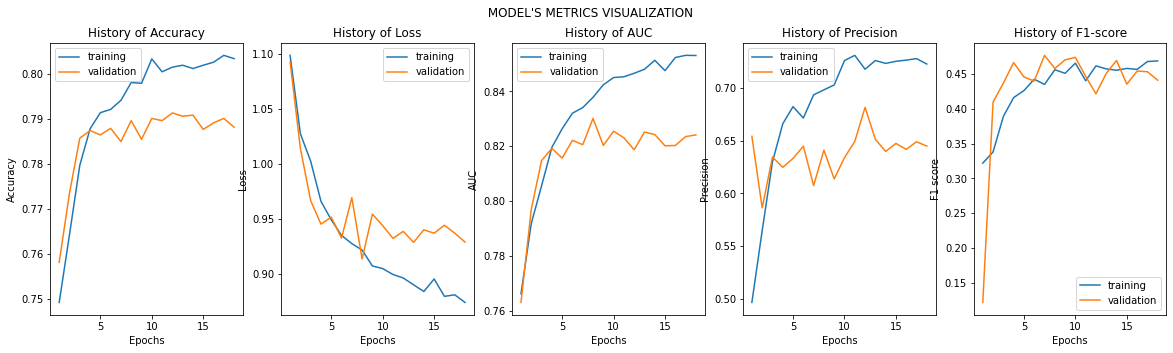

In [84]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [85]:
scores = model.evaluate(test_dataset)

40/40 [==============================] - 14s 352ms/step - loss: 0.9900 - accuracy: 0.7824 - precision: 0.5856 - recall: 0.4441 - auc: 0.8279 - f1_score: 0.5037


In [86]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7824472188949585
Precision =  0.5855669975280762
Recall =  0.44409695267677307
AUC =  0.8279309868812561
F1_score =  0.503696858882904


In [87]:
def predict_prob(number):
  return [number[0],1-number[0]]

66.59 % chances are there that the image is [2]


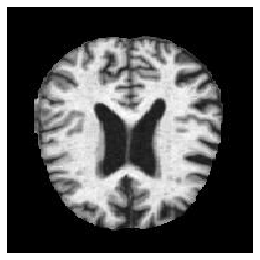

In [88]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (48).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

In [89]:
#model.save('/kaggle/working/zahaimar_v2.h5')

In [90]:
test_acc = model.evaluate(valid_dataset, verbose = 2)
print("\nTest accuracy: ", test_acc[1])

32/32 - 11s - loss: 0.9137 - accuracy: 0.7896 - precision: 0.6411 - recall: 0.3597 - auc: 0.8301 - f1_score: 0.4585

Test accuracy:  0.7895894646644592


In [91]:
import numpy as np
import pandas as pd 
import seaborn as sn 
import tensorflow as tf

In [92]:
print(train_dataset.class_indices.keys())

dict_keys(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])


In [93]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [94]:
from sklearn.metrics import classification_report

Y_pred = model.predict(valid_dataset)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(valid_dataset.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.00      0.00      0.00        10
           2       0.50      0.61      0.55       512
           3       0.36      0.39      0.38       358

    accuracy                           0.44      1023
   macro avg       0.21      0.25      0.23      1023
weighted avg       0.38      0.44      0.41      1023



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


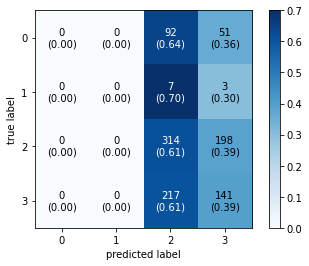

In [95]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(valid_dataset.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()